In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import itertools
from time import sleep
import os
import seaborn as sns
from itertools import chain

In [2]:
print datetime.datetime.now()
validFilePaths = []
for f in os.listdir("data/anomaly_data"):
    filePath = os.path.join("data/anomaly_data", f)
    if os.path.isdir(filePath):
        continue
    if os.stat(filePath).st_size <= 3:
        continue
    validFilePaths.append(filePath)
    
numF = int(1 * len(validFilePaths))
print 'Using this many files {0}'.format(numF)
validFilePaths = np.random.choice(validFilePaths, numF, replace=False)
df_list = (pd.read_csv(f) for f in validFilePaths)
df = pd.concat(df_list, ignore_index=True)
df = df[df['radiant_win'].notnull()]

2017-06-11 21:06:54.122046
Using this many files 4088


In [3]:
df2 = pd.DataFrame(np.loadtxt('data/goodAnomaliesResidual.csv', delimiter = ','), 
                 columns = ["match_id", "residual"])

df = df.merge(df2, left_on='match_id', right_on='match_id')

matchDictionary = {}
heroColumns = [filter(lambda x: z in x, df.columns) for z in ['hero_id']][0]

# for each row, this function will return all the heroes that the match belongs in
# for example, if the match had an AM and Spectre, we should place this match in each of those bags
def heroesForMatch(row):
    pass

In [4]:
df = df[~df['match_id'].duplicated()]

In [5]:
df = df.sort_values(by='residual', ascending=False)

In [6]:
columns = df.columns
numericalFeatures = ['match_id', 'positive_votes', 'negative_votes', 'first_blood_time', 'radiant_win',
                    'duration', 'kills', 'deaths', 'assists', 'kpm', 'kda', 'hero_dmg',
                    'gpm', 'hero_heal', 'xpm', 'totalgold', 'totalxp', 'lasthits', 'denies',
                    'tower_kills', 'courier_kills', 'observer_uses', 'sentry_uses',
                    'ancient_kills', 'camps_stacked', 'abandons', 'residual']
numFeatures = [filter(lambda x: z in x, columns) for z in numericalFeatures]
numFeatures = list(chain(*numFeatures))
df = df[numFeatures]

In [7]:
df['match_id'].values.tolist()

[3215497967,
 3215097220,
 3215312675,
 3215162338,
 3215181105,
 3215377994,
 3215271631,
 3215289100,
 3215279863,
 3215253055,
 3215448302,
 3215416370,
 3215261563,
 3215294948,
 3215155134,
 3215350255,
 3215341221,
 3215306187,
 3215302636,
 3215316820,
 3215190109,
 3215355847,
 3215130854,
 3215259897,
 3215394671,
 3215152225,
 3215274711,
 3215366609,
 3215449992,
 3215376405,
 3215268540,
 3215420902,
 3215332931,
 3215327547,
 3215354992,
 3215254939,
 3215149372,
 3215370025,
 3215201012,
 3215272070,
 3215223639,
 3215422492,
 3215260456,
 3215354934,
 3215377592,
 3215445972,
 3215101148,
 3215174827,
 3215384305,
 3215188370,
 3215297782,
 3215493515,
 3215119808,
 3215360521,
 3215102154,
 3215271055,
 3215403667,
 3215217460,
 3215482564,
 3215466626,
 3215255292,
 3215095789,
 3215108689,
 3215330831,
 3215468550,
 3215446132,
 3215384555,
 3215470445,
 3215318005,
 3215238829,
 3215293087,
 3215391855,
 3215439074,
 3215401870,
 3215440922,
 3215092973,
 3215369622,

In [8]:
df['residual'].values.tolist()

[60.09383010864258,
 22.98058319091797,
 14.018461227416992,
 12.276541709899902,
 10.960655212402344,
 10.190336227416992,
 9.797115325927734,
 8.665862083435059,
 8.291083335876465,
 6.753566265106201,
 5.982767105102539,
 5.009283542633057,
 4.787799835205078,
 4.737585544586182,
 4.151325702667236,
 3.8586721420288086,
 3.7200565338134766,
 3.653451919555664,
 3.6120126247406006,
 3.55796217918396,
 3.5249321460723877,
 3.4550528526306152,
 3.4301578998565674,
 2.9261271953582764,
 2.8132457733154297,
 2.767648220062256,
 2.758488178253174,
 2.543581247329712,
 2.5158803462982178,
 2.4831578731536865,
 2.4762089252471924,
 2.392141342163086,
 2.38230299949646,
 2.3297765254974365,
 2.2398288249969482,
 2.229811429977417,
 2.1894421577453613,
 2.1700241565704346,
 2.150897741317749,
 2.0817346572875977,
 2.0602142810821533,
 2.044538974761963,
 2.038116693496704,
 2.0010886192321777,
 1.953024983406067,
 1.9425238370895386,
 1.919196367263794,
 1.8698474168777466,
 1.823149442672729

In [24]:
np.percentile(df['residual'], .9)

0.08401429408043623

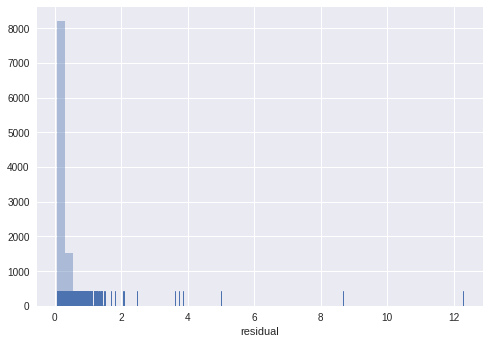

In [9]:
sns.distplot(df['residual'].sample(n=10000),  kde=False, rug=True)
plt.show()

In [10]:
len(df)

42798

In [11]:
plt.close()

In [12]:
residuals = df['residual'].values.tolist()

In [13]:
np.max(residuals) - np.min(residuals)

60.033355519175529

In [14]:
df['residual']

17245    60.093830
25851    22.980583
32719    14.018461
35115    12.276542
9930     10.960655
19554    10.190336
31901     9.797115
24340     8.665862
36960     8.291083
28275     6.753566
31388     5.982767
13479     5.009284
24387     4.787800
351       4.737586
42569     4.151326
11355     3.858672
4883      3.720057
32269     3.653452
32863     3.612013
39268     3.557962
1169      3.524932
35184     3.455053
8953      3.430158
31184     2.926127
16333     2.813246
26863     2.767648
40304     2.758488
21453     2.543581
27056     2.515880
3193      2.483158
           ...    
37500     0.069483
945       0.069253
6926      0.069227
3273      0.069197
2614      0.069074
11297     0.069049
29169     0.068937
30480     0.068805
40193     0.068641
24596     0.068497
23944     0.068060
10411     0.067955
40561     0.067766
28527     0.067643
39189     0.067419
22327     0.066208
38772     0.065560
12674     0.065004
19113     0.064927
6387      0.064823
40763     0.064179
4587      0.

In [15]:
def RadiantDireDifference(row, column):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    radiantSum = 0
    direSum = 0
    for pos in poss:
        radiantSum += row['radiant_'+ pos + '_' + column]
        direSum += row['dire_'+ pos + '_' + column]
    return radiantSum - direSum

def reject_outliers(data, m=1.5):
    return abs(data - np.mean(data)) < m * np.std(data)


def heroKDAdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] + \
                        row[fac + '_' + pos + '_assists'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def heroKDdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def heroKD(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = int(pos[3:4])
    return returnVal

def heroGoldSpent(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_gold_spent']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = int(pos[3:4])
    return returnVal

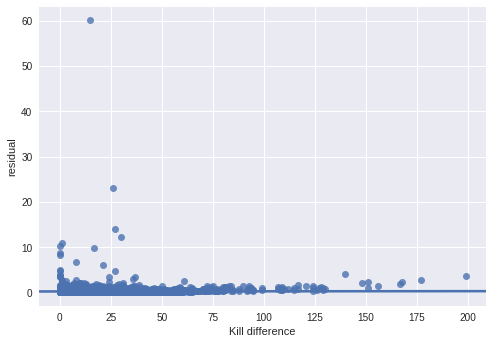

In [16]:
kill_difference = np.abs(df.apply(RadiantDireDifference, args=('kills',), axis=1))
sns.regplot(kill_difference, df['residual'])
ax = plt.gca()
ax.set_xlabel("Kill difference")
plt.show()

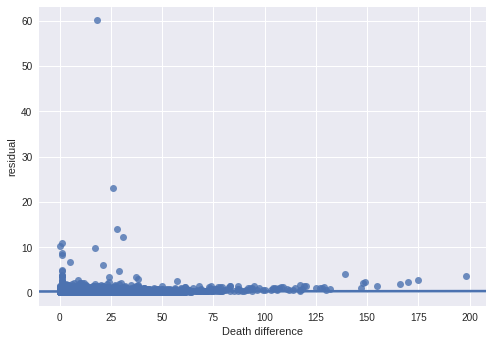

In [17]:
death_difference = df.apply(RadiantDireDifference, args=('deaths',), axis=1)
sns.regplot(np.abs(death_difference), df['residual'])
ax = plt.gca()
ax.set_xlabel("Death difference")
plt.show()

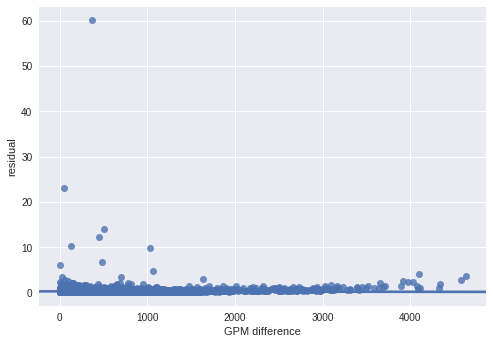

In [18]:
gold_difference = df.apply(RadiantDireDifference, args=('gpm',), axis=1)
above_ = np.abs(gold_difference) <= 5000

indices = np.where(above_)[0]
sns.regplot(np.abs(gold_difference)[above_], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("GPM difference")
plt.show()

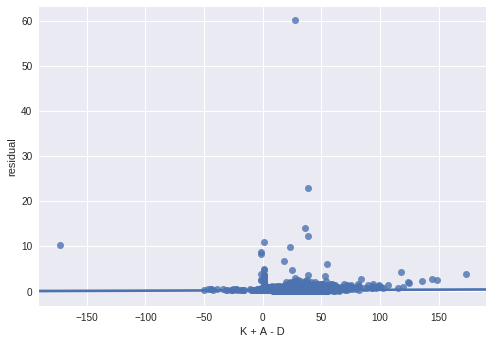

In [19]:
kda = df.apply(heroKDAdeficit, axis=1)
sns.regplot(kda, df['residual'])
ax = plt.gca()
ax.set_xlabel("K + A - D")
plt.show()

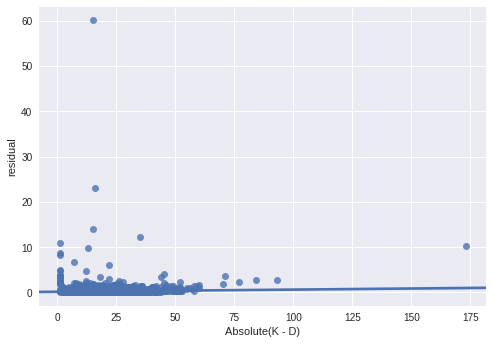

In [20]:
kd = df.apply(heroKDdeficit, axis=1)
sns.regplot(np.abs(kd), df['residual'])
ax = plt.gca()
ax.set_xlabel("Absolute(K - D)")
plt.show()

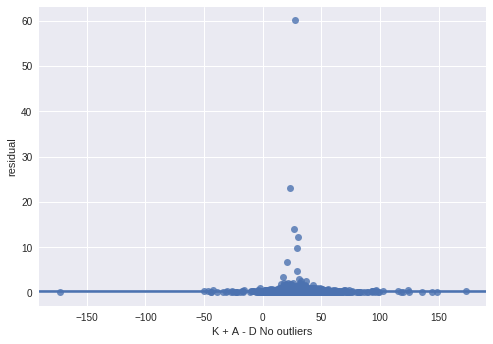

In [21]:
kda = df.apply(heroKDAdeficit, axis=1)
kda_mean = np.mean(kda)
kda_std = np.std(kda)
indices = np.where(np.logical_and(kda <= kda_mean + 1.5*kda_std, kda >= kda_mean-1.5*kda_std))[0]
sns.regplot(kda[indices], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("K + A - D No outliers")
plt.show()

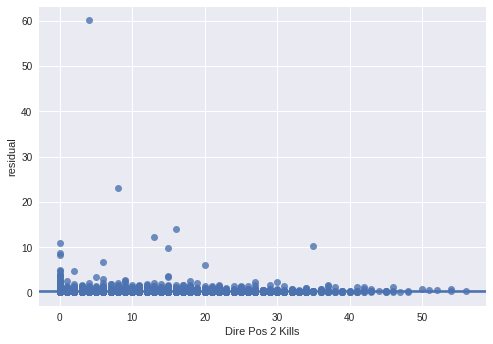

In [22]:
sns.regplot(df['dire_pos2_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Dire Pos 2 Kills")
plt.show()

KeyboardInterrupt: 

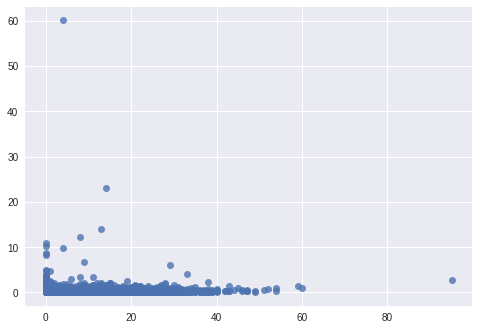

In [23]:
sns.regplot(df['radiant_pos1_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills")
plt.show()

In [ ]:
sns.regplot(np.abs(df['radiant_pos1_kills'] - df['radiant_pos1_deaths']), df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills - Deaths")
plt.show()

In [ ]:
sns.regplot(df['radiant_pos5_kills'] - df['radiant_pos5_deaths'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 5 Kills - Deaths")
plt.show()

In [ ]:
sns.regplot(df.apply(heroKD, axis=1), df['residual'])
ax = plt.gca()
ax.set_xlabel("Hero Pos")
plt.show()

In [ ]:
sns.regplot(df['duration'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Duration")
plt.show()

In [26]:
df[df['residual'] > 0.08]

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
17245,3215497967,49,2,14,True,2748,43.0,0.0,4,141.0,...,0,0,0,0,0,0,0,0,0,60.093830
25851,3215097220,15,7,15,True,2470,23.0,0.0,7,108.0,...,0,0,0,0,0,0,0,0,0,22.980583
32719,3215312675,9,4,0,False,2687,0.0,0.0,10,9.0,...,0,0,0,0,0,0,0,0,0,14.018461
35115,3215162338,0,0,135,False,3981,18.0,21.0,27,70.0,...,0,0,0,0,0,0,0,0,0,12.276542
9930,3215181105,0,0,0,True,0,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,1,0,10.960655
19554,3215377994,0,0,72,False,2924,NaN,NaN,28,NaN,...,0,0,0,0,0,0,0,0,0,10.190336
31901,3215271631,7,1,3,False,1846,4.0,0.0,5,36.0,...,0,0,0,0,0,0,0,0,0,9.797115
24340,3215289100,0,0,0,False,0,NaN,NaN,0,NaN,...,0,0,1,0,0,0,0,0,0,8.665862
36960,3215279863,0,0,0,False,0,NaN,NaN,0,NaN,...,0,0,1,0,0,0,0,0,0,8.291083
28275,3215253055,5,0,182,True,1949,0.0,0.0,4,10.0,...,0,0,0,0,0,0,0,0,0,6.753566


In [25]:
df[df['residual'] < 0.08].sample(10, random_state=1)

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
9633,3215345247,0,0,130,True,2724,NaN,NaN,7,NaN,...,0,0,0,0,0,0,0,0,0,0.077793
31772,3215385097,0,0,142,True,2817,NaN,NaN,2,NaN,...,0,0,0,0,0,0,0,0,0,0.074403
10652,3215189135,0,0,77,True,2633,NaN,NaN,10,NaN,...,0,0,0,0,0,0,0,0,0,0.073280
18552,3215370398,0,0,13,True,2539,NaN,NaN,10,NaN,...,0,0,0,0,0,0,0,0,0,0.060731
24746,3215453195,0,0,226,True,2607,NaN,NaN,11,NaN,...,0,0,0,0,0,0,0,0,0,0.070520
14964,3215287528,0,0,103,True,2815,NaN,NaN,5,NaN,...,0,0,0,0,0,0,0,0,0,0.077429
23944,3215091914,0,0,120,False,2710,NaN,NaN,18,NaN,...,0,0,0,0,0,0,0,0,0,0.068060
8363,3215342354,0,0,230,True,2475,NaN,NaN,10,NaN,...,0,0,0,0,0,0,0,0,0,0.075910
28527,3215359693,0,0,68,True,2461,NaN,NaN,5,NaN,...,0,0,0,0,0,0,0,0,0,0.067643
26665,3215390401,0,0,175,True,2414,NaN,NaN,8,NaN,...,0,0,0,0,0,0,0,0,0,0.078218


In [27]:
biggestAnom = np.loadtxt('data/anomalies.csv', delimiter = ',')
theirOutput = np.loadtxt('data/output.csv', delimiter = ",")

In [30]:
def whichIndex(row1, row2):
    largestError = -1
    index = -1
    for i in range(1, len(row1)):
        if abs(row1[i] - row2[i]) > largestError:
            largestError = abs(row1[i] - row2[i])
            index = i
    return index
columns = list(df.columns)
columns.remove('match_id')
for i in range(len(biggestAnom)):
    index = whichIndex(biggestAnom[i, :], theirOutput[i, :])
    df.columns[index]
    print index, columns[index], biggestAnom[i, index], theirOutput[i, index]

3 radiant_win 1.0 0.039147272706
3 radiant_win 1.0 0.56743657589
118 dire_pos4_hero_heal 0.67755907774 0.33141413331
188 dire_pos4_courier_kills 0.997236430645 0.254108220339
111 radiant_pos2_gpm 0.967831552029 0.215277791023
88 dire_pos4_kda 0.986187636852 0.675353765488
9 dire_pos1_tower_kills 0.447501391172 0.305381178856
107 dire_pos3_gpm 0.915403366089 0.162800624967
107 dire_pos3_gpm 0.915403366089 0.155206382275
180 radiant_pos1_tower_kills 0.440713703632 0.349808007479
209 dire_pos5_sentry_uses 0.977942168713 0.730815529823
106 dire_pos2_gpm 0.0236208867282 0.595808267593
111 radiant_pos2_gpm 0.243853777647 0.536930799484
173 radiant_pos4_denies 0.228183165193 0.189430326223
51 radiant_pos5_courier_kills 0.996014475822 0.729707717896
112 radiant_pos3_gpm 0.172037020326 0.478152662516
79 dire_pos5_kpm 0.765351176262 0.473023504019
110 radiant_pos1_gpm 0.796920537949 0.594073414803
107 dire_pos3_gpm 0.995038449764 0.616404891014
108 dire_pos4_gpm 0.995248615742 0.661065816879
206

In [ ]:
set(theirOutput[:, 9])

In [ ]:
set(biggestAnom[:, 9])

In [ ]:
bias_1 = pd.read_csv('data/bias1.csv')

In [ ]:
bias_1

In [ ]:
weights_1 = pd.read_csv('data/weights1.csv')
weights_1

In [29]:
df.columns

Index([u'match_id', u'positive_votes', u'negative_votes', u'first_blood_time',
       u'radiant_win', u'duration', u'dire_pos1_ancient_kills',
       u'dire_pos1_courier_kills', u'dire_pos1_kills',
       u'dire_pos1_neutral_kills',
       ...
       u'dire_pos2_abandons', u'dire_pos3_abandons', u'dire_pos4_abandons',
       u'dire_pos5_abandons', u'radiant_pos1_abandons',
       u'radiant_pos2_abandons', u'radiant_pos3_abandons',
       u'radiant_pos4_abandons', u'radiant_pos5_abandons', u'residual'],
      dtype='object', length=247)